In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.1 MB/s eta 0:00:00


In [ ]:
!pip install -q git+https://github.com/keras-team/keras-cv

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 13.6 MB/s eta 0:00:00


In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import pydicom
import random
from sklearn.model_selection import GroupKFold, train_test_split
import sys
import torch

pd.set_option("display.max_colwidth", -1)
pd.set_option('display.max_rows', None)

<ipython-input-5-0acb7e53abe8>:25: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [ ]:
class Config:
  SEED = 42
  BASE_PATH = "/content/drive/MyDrive/png_test_lyd"
  TEST_PATH = "/content/drive/MyDrive/png_test_lyd"
  IMAGE_SIZE = [256, 256]
  PARAMETER = 'g0.5'
  BATCH_SIZE = 1
  EPOCHS = 10
  TARGET_COLS = [
      "bowel_injury", "extravasation_injury",
      "kidney_healthy", "kidney_low", "kidney_high",
      "liver_healthy", "liver_low", "liver_high",
      "spleen_healthy", "spleen_low", "spleen_high",
  ]

In [ ]:
config = Config()

In [ ]:
random_seed = config.SEED
np.random.seed(random_seed)
set_determinism(random_seed)

DATA PREPROCESSING PIPELINE

In [ ]:
BASE_PATH = config.BASE_PATH
TEST_PATH = config.TEST_PATH
IMAGE_SIZE = config.IMAGE_SIZE
PARAMETER = config.PARAMETER
width, height = config.IMAGE_SIZE

In [ ]:
image_level_labels_path = "image_level_labels.csv"
train_csv_path = "train.csv"
test_csv_path = "sample_submission.csv"

In [ ]:
train_csv = pd.read_csv(f'{BASE_PATH}/{train_csv_path}')
test_csv = pd.read_csv(f'{BASE_PATH}/{test_csv_path}')

In [ ]:
# collect the files for train
train_img_paths = glob(f'{TEST_PATH}/*/*/*{IMAGE_SIZE}*{PARAMETER}/*.png')
print(f'Total number of images {len(train_img_paths)}')

Total number of images 12512


In [ ]:
dataframe = pd.DataFrame(train_img_paths, columns=["image_path"])
# dataframe = dataframe.drop_duplicates()
dataframe['patient_id'] = dataframe.image_path.map(lambda x: x.split('/')[-4]).astype(int)
dataframe['series_id'] = dataframe.image_path.map(lambda x: x.split('/')[-3]).astype(int)
dataframe['width'] = width
dataframe['height'] = height
dataframe = dataframe.merge(train_csv, on='patient_id', how='inner')

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12512 entries, 0 to 12511
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   image_path             12512 non-null  object
 1   patient_id             12512 non-null  int64 
 2   series_id              12512 non-null  int64 
 3   width                  12512 non-null  int64 
 4   height                 12512 non-null  int64 
 5   bowel_healthy          12512 non-null  int64 
 6   bowel_injury           12512 non-null  int64 
 7   extravasation_healthy  12512 non-null  int64 
 8   extravasation_injury   12512 non-null  int64 
 9   kidney_healthy         12512 non-null  int64 
 10  kidney_low             12512 non-null  int64 
 11  kidney_high            12512 non-null  int64 
 12  liver_healthy          12512 non-null  int64 
 13  liver_low              12512 non-null  int64 
 14  liver_high             12512 non-null  int64 
 15  spleen_healthy     

In [ ]:
dataframe.head(5)

,image_path,patient_id,series_id,width,height,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,any_injury
0,/content/drive/MyDrive/png_test_lyd/10004/21057/img_225x225_d1_g0.5/image_22.png,10004,21057,256,256,1,0,0,1,0,1,0,1,0,0,0,0,1,1
1,/content/drive/MyDrive/png_test_lyd/10004/21057/img_225x225_d1_g0.5/image_23.png,10004,21057,256,256,1,0,0,1,0,1,0,1,0,0,0,0,1,1
2,/content/drive/MyDrive/png_test_lyd/10004/21057/img_225x225_d1_g0.5/image_24.png,10004,21057,256,256,1,0,0,1,0,1,0,1,0,0,0,0,1,1
3,/content/drive/MyDrive/png_test_lyd/10004/21057/img_225x225_d1_g0.5/image_25.png,10004,21057,256,256,1,0,0,1,0,1,0,1,0,0,0,0,1,1
4,/content/drive/MyDrive/png_test_lyd/10004/21057/img_225x225_d1_g0.5/image_26.png,10004,21057,256,256,1,0,0,1,0,1,0,1,0,0,0,0,1,1


In [ ]:
# Function to handle the split for each group
def split_group(group, test_size=0.2):
    if len(group) == 1:
        return (group, pd.DataFrame()) if np.random.rand() < test_size else (pd.DataFrame(), group)
    else:
        return train_test_split(group, test_size=test_size, random_state=42)

# Initialize the train and validation datasets
train_data = pd.DataFrame()
val_data = pd.DataFrame()

# Iterate through the groups and split them, handling single-sample groups
for _, group in dataframe.groupby(config.TARGET_COLS):
    train_group, val_group = split_group(group)
    train_data = pd.concat([train_data, train_group], ignore_index=True)
    val_data = pd.concat([val_data, val_group], ignore_index=True)

train_data.shape, val_data.shape

((10009, 19), (2503, 19))

In [ ]:
train_data.columns

Index(['image_path', 'patient_id', 'series_id', 'width', 'height',
       'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury'],
      dtype='object')

In [ ]:
paths  = train_data.image_path.tolist()
labels = train_data[config.TARGET_COLS].values

In [ ]:
import os
# You can use `tensorflow`, `pytorch`, `jax` here
# KerasCore makes the notebook backend agnostic :)
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_cv
import keras_core as keras
from keras_core import layers

import tensorflow as tf

Using TensorFlow backend


In [ ]:
def decode_image_and_label(image_path, label):
    file_bytes = tf.io.read_file(image_path)
    image = tf.io.decode_png(file_bytes, channels=3, dtype=tf.uint8)
    image = tf.image.resize(image, config.IMAGE_SIZE, method="bilinear")
    image = tf.cast(image, tf.float32) / 255.0

    label = tf.cast(label, tf.float32)
    #         bowel       fluid       kidney      liver       spleen
    labels = (label[0:1], label[1:2], label[2:5], label[5:8], label[8:11])

    return (image, labels)


def apply_augmentation(images, labels):
    augmenter = keras_cv.layers.Augmenter(
        [
            # keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomCutout(height_factor=0.2, width_factor=0.2),

        ]
    )
    return (augmenter(images), labels)


def build_dataset(image_paths, labels):
    ds = (
        tf.data.Dataset.from_tensor_slices((image_paths, labels))
        .map(decode_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(config.BATCH_SIZE * 10)
        .batch(config.BATCH_SIZE)
        .map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )
    return ds

In [ ]:
ds = build_dataset(paths, labels)
images, labels = next(iter(ds))
images.shape, [label.shape for label in labels]

(TensorShape([1, 256, 256, 3]),
 [TensorShape([1, 1]),
  TensorShape([1, 1]),
  TensorShape([1, 3]),
  TensorShape([1, 3]),
  TensorShape([1, 3])])

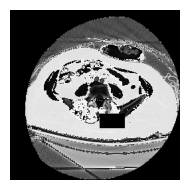

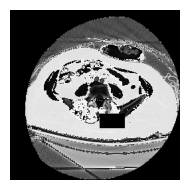

In [ ]:
# No more customizing your plots by hand, KerasCV has your back ;)
keras_cv.visualization.plot_image_gallery(
    images=images,
    value_range=(0, 1),
    rows=1,
    cols=1,
)

In [ ]:
def build_model(warmup_steps, decay_steps):
    # Define Input
    inputs = keras.Input(shape=config.IMAGE_SIZE + [3,], batch_size=config.BATCH_SIZE)

    # Define Backbone
    backbone = keras_cv.models.ResNetBackbone.from_preset("resnet50_imagenet")
    backbone.include_rescaling = False
    x = backbone(inputs)

    # GAP to get the activation maps
    gap = keras.layers.GlobalAveragePooling2D()
    x = gap(x)

    # Define 'necks' for each head
    x_bowel = keras.layers.Dense(32, activation='silu')(x)
    x_extra = keras.layers.Dense(32, activation='silu')(x)
    x_liver = keras.layers.Dense(32, activation='silu')(x)
    x_kidney = keras.layers.Dense(32, activation='silu')(x)
    x_spleen = keras.layers.Dense(32, activation='silu')(x)

    # Define heads
    out_bowel = keras.layers.Dense(1, name='bowel', activation='sigmoid')(x_bowel) # use sigmoid to convert predictions to [0-1]
    out_extra = keras.layers.Dense(1, name='extra', activation='sigmoid')(x_extra) # use sigmoid to convert predictions to [0-1]
    out_liver = keras.layers.Dense(3, name='liver', activation='softmax')(x_liver) # use softmax for the liver head
    out_kidney = keras.layers.Dense(3, name='kidney', activation='softmax')(x_kidney) # use softmax for the kidney head
    out_spleen = keras.layers.Dense(3, name='spleen', activation='softmax')(x_spleen) # use softmax for the spleen head

    # Concatenate the outputs
    outputs = [out_bowel, out_extra, out_liver, out_kidney, out_spleen]

    # Create model
    print("[INFO] Building the model...")
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Cosine Decay
    cosine_decay = keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=1e-4,
        decay_steps=decay_steps,
        alpha=0.0,
        warmup_target=1e-3,
        warmup_steps=warmup_steps,
    )

    # Compile the model
    optimizer = keras.optimizers.Adam(learning_rate=cosine_decay)
    loss = {
        "bowel":keras.losses.BinaryCrossentropy(),
        "extra":keras.losses.BinaryCrossentropy(),
        "liver":keras.losses.CategoricalCrossentropy(),
        "kidney":keras.losses.CategoricalCrossentropy(),
        "spleen":keras.losses.CategoricalCrossentropy(),
    }
    metrics = {
        "bowel":["accuracy"],
        "extra":["accuracy"],
        "liver":["accuracy"],
        "kidney":["accuracy"],
        "spleen":["accuracy"],
    }
    print("[INFO] Compiling the model...")
    model.compile(
        optimizer=optimizer,
      loss=loss,
      metrics=metrics
    )

    return model

In [ ]:
# get image_paths and labels
print("[INFO] Building the dataset...")
train_paths = train_data.image_path.values; train_labels = train_data[config.TARGET_COLS].values.astype(np.float32)
valid_paths = val_data.image_path.values; valid_labels = val_data[config.TARGET_COLS].values.astype(np.float32)

# train and valid dataset
train_ds = build_dataset(image_paths=train_paths, labels=train_labels)
val_ds = build_dataset(image_paths=valid_paths, labels=valid_labels)

total_train_steps = train_ds.cardinality().numpy() * config.BATCH_SIZE * config.EPOCHS
warmup_steps = int(total_train_steps * 0.10)
decay_steps = total_train_steps - warmup_steps

print(f"{total_train_steps=}")
print(f"{warmup_steps=}")
print(f"{decay_steps=}")

[INFO] Building the dataset...


NameError: ignored

In [ ]:
# build the model
print("[INFO] Building the model...")
model = build_model(warmup_steps, decay_steps)

# train
print("[INFO] Training...")
history = model.fit(
    train_ds,
    epochs=config.EPOCHS,
    validation_data=val_ds,
)

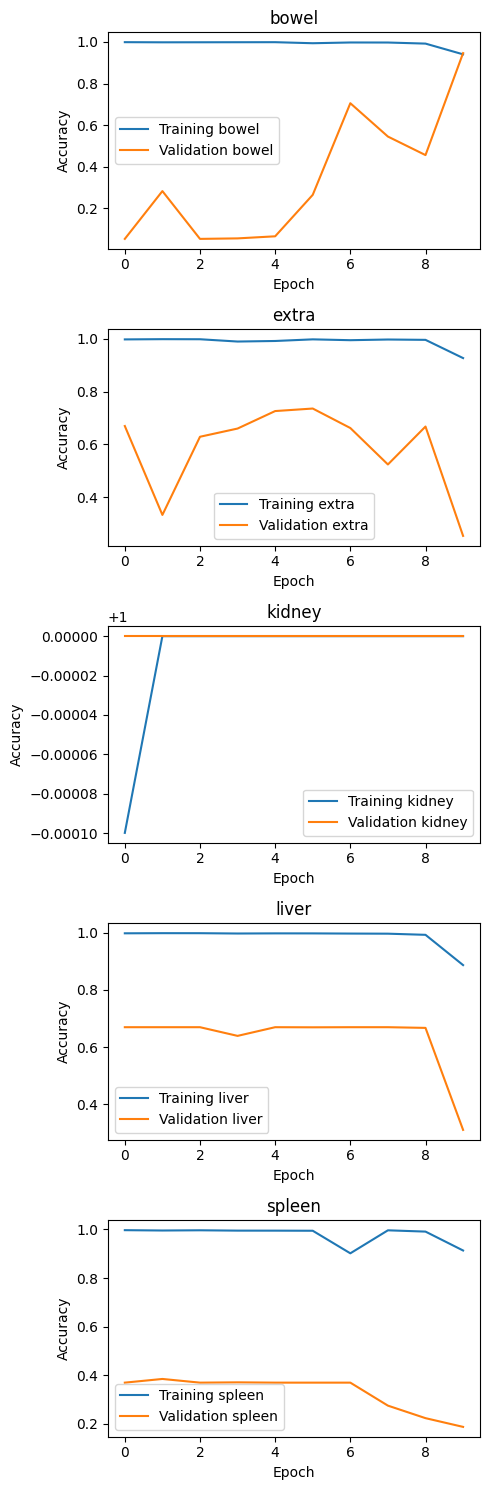

In [ ]:
# Create a 3x2 grid for the subplots
fig, axes = plt.subplots(5, 1, figsize=(5, 15))

# Flatten axes to iterate through them
axes = axes.flatten()

# Iterate through the metrics and plot them
for i, name in enumerate(["bowel", "extra", "kidney", "liver", "spleen"]):
    # Plot training accuracy
    axes[i].plot(history.history[name + '_accuracy'], label='Training ' + name)
    # Plot validation accuracy
    axes[i].plot(history.history['val_' + name + '_accuracy'], label='Validation ' + name)
    axes[i].set_title(name)
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Accuracy')
    axes[i].legend()

plt.tight_layout()
plt.show()

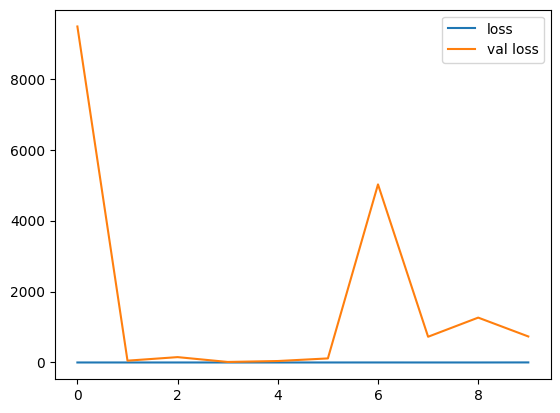

In [ ]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.show()

In [ ]:
# store best results
best_epoch = np.argmin(history.history['val_loss'])
best_loss = history.history['val_loss'][best_epoch]
best_acc_bowel = history.history['val_bowel_accuracy'][best_epoch]
best_acc_extra = history.history['val_extra_accuracy'][best_epoch]
best_acc_liver = history.history['val_liver_accuracy'][best_epoch]
best_acc_kidney = history.history['val_kidney_accuracy'][best_epoch]
best_acc_spleen = history.history['val_spleen_accuracy'][best_epoch]

# Find mean accuracy
best_acc = np.mean(
    [best_acc_bowel,
     best_acc_extra,
     best_acc_liver,
     best_acc_kidney,
     best_acc_spleen
])


print(f'>>>> BEST Loss  : {best_loss:.3f}\n>>>> BEST Acc   : {best_acc:.3f}\n>>>> BEST Epoch : {best_epoch}\n')
print('ORGAN Acc:')
print(f'  >>>> {"Bowel".ljust(15)} : {best_acc_bowel:.3f}')
print(f'  >>>> {"Extravasation".ljust(15)} : {best_acc_extra:.3f}')
print(f'  >>>> {"Liver".ljust(15)} : {best_acc_liver:.3f}')
print(f'  >>>> {"Kidney".ljust(15)} : {best_acc_kidney:.3f}')
print(f'  >>>> {"Spleen".ljust(15)} : {best_acc_spleen:.3f}')

>>>> BEST Loss  : 14.808
>>>> BEST Acc   : 0.545
>>>> BEST Epoch : 3

ORGAN Acc:
  >>>> Bowel           : 0.056
  >>>> Extravasation   : 0.660
  >>>> Liver           : 0.639
  >>>> Kidney          : 1.000
  >>>> Spleen          : 0.370
